In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import nltk, re, itertools
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
df = pd.read_csv('Example_Dataset - Semiconductor.csv')

In [4]:
# reformat the timestamp column
df['Date'] = pd.to_datetime(df.Date)

In [5]:
# only keep instances using the same unit
df = df[df.Performance.str.endswith('cm-2')]

In [6]:
# load the models
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained("allenai/specter")

In [7]:
# clean the text
texts = [re.sub(r'[^a-zA-Z0-9\s]', '', text) for text in df.Content.values]
texts = [re.sub(r'\s+', ' ', text).strip() for text in df.Content.values]

In [8]:
# preprocess the input
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
result = model(**inputs)

In [9]:
# take the first token in the batch as the embedding
embeddings = result.last_hidden_state[:, 0, :]

In [10]:
# put the embedding back into the dataframe
df['Embedding'] = [embedding for embedding in embeddings.detach().numpy()]

In [11]:
# remove the unit in the performance column
df['Performance'] = [float(i.replace('mA cm-2', '').strip()) for i in df['Performance']]

In [12]:
# calculate pairwise distance of embeddings, time, and performance
df2 = pd.DataFrame(columns=['Index_Pair', 'Time_Distance', 'Performance_Distance',
                            'Embedding_Distance(Eucliden)', 'Embedding_Distance(CosinSim)'])

pairs = list(itertools.combinations(df.index, 2))

for pair in pairs:
    # get time distance /day
    time_dist = abs((df.loc[pair[0], 'Date'] - df.loc[pair[1], 'Date']).days)
    # get performane distance
    perf_dist = np.log(abs(df.loc[pair[0], 'Performance'] - df.loc[pair[1], 'Performance'])+1)
    # get embedding distance
    embed_dist1 = abs(pairwise_distances(df.loc[pair[0], 'Embedding'].reshape(1, -1),
                                     df.loc[pair[1], 'Embedding'].reshape(1, -1),
                                     metric='euclidean')[0][0])
    embed_dist2 = abs(cosine_similarity(df.loc[pair[0], 'Embedding'].reshape(1, -1),
                                    df.loc[pair[1], 'Embedding'].reshape(1, -1))[0][0])
    
    df2 = df2.append({'Index_Pair': pair,
                      'Time_Distance': float(time_dist),
                      'Performance_Distance': float(perf_dist),
                      'Embedding_Distance(Eucliden)': float(embed_dist1),
                      'Embedding_Distance(CosinSim)': float(embed_dist2)}, ignore_index=True)

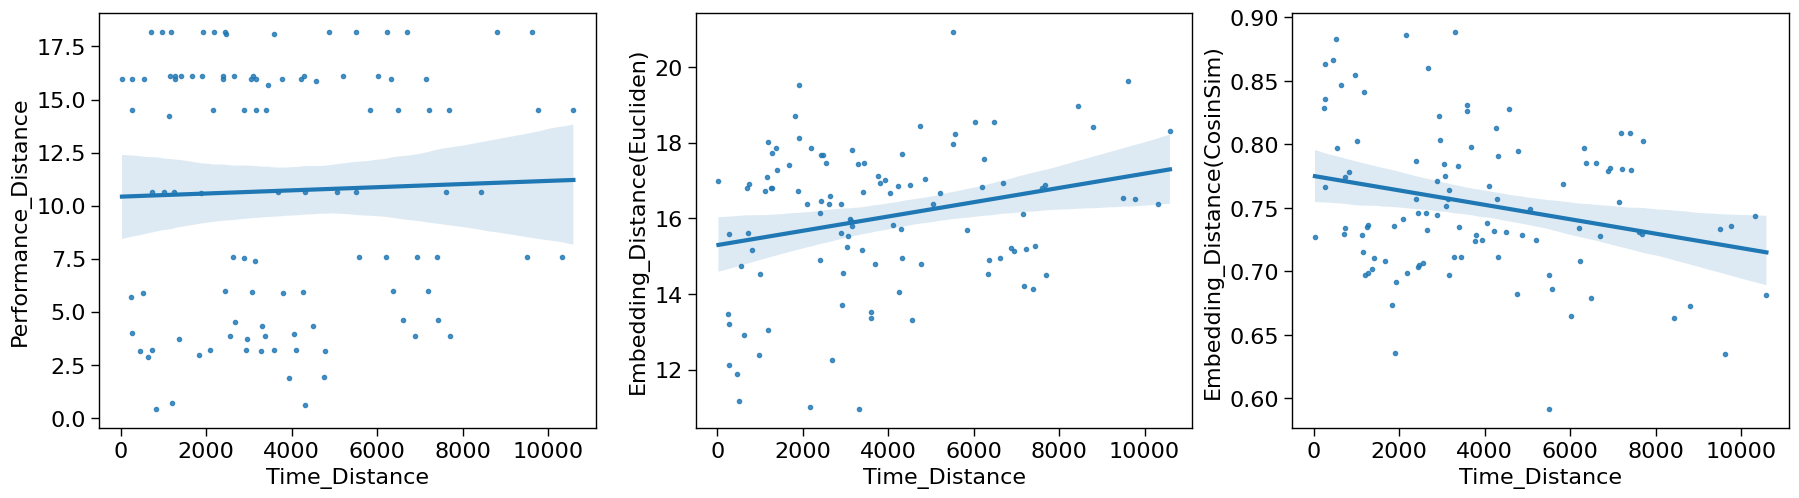

In [13]:
plt.style.use(['nature', 'notebook'])
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.regplot(x=df2['Time_Distance'], y=df2['Performance_Distance'], ax=axs[0])
sns.regplot(x=df2['Time_Distance'], y=df2['Embedding_Distance(Eucliden)'], ax=axs[1])
sns.regplot(x=df2['Time_Distance'], y=df2['Embedding_Distance(CosinSim)'], ax=axs[2])
plt.tight_layout()
plt.show()

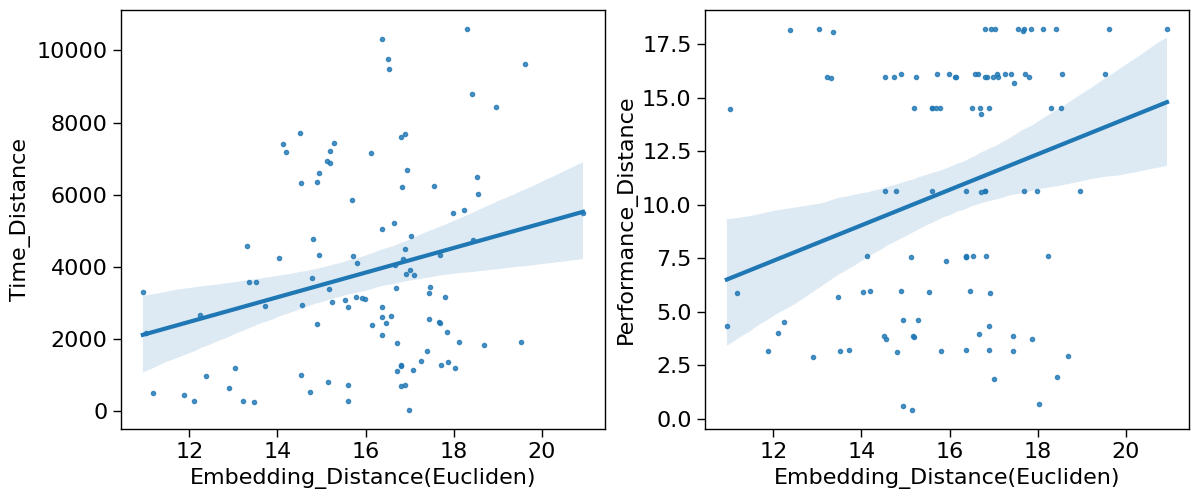

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
sns.regplot(x=df2['Embedding_Distance(Eucliden)'], y=df2['Time_Distance'], ax=axs[0])
sns.regplot(x=df2['Embedding_Distance(Eucliden)'], y=df2['Performance_Distance'], ax=axs[1])
plt.tight_layout()
plt.show()

In [173]:
df2

,Index_Pair,Time_Distance,Performance_Distance,Embedding_Distance(Eucliden),Embedding_Distance(CosinSim)
0,"(0, 1)",1186.0,-2.525729,18.381193,0.674821
1,"(0, 2)",182.0,-1.660731,13.108189,0.834414
2,"(0, 3)",7092.0,-4.605170,19.224373,0.644187
3,"(0, 4)",4505.0,-2.995732,17.983084,0.686304
4,"(0, 5)",1522.0,-2.659260,6.953122,0.952884
5,"(0, 6)",640.0,-4.605170,8.813907,0.925429
6,"(1, 2)",1004.0,-1.309333,18.504473,0.673891
7,"(1, 3)",8278.0,-2.407946,21.035421,0.579053
8,"(1, 4)",5691.0,-2.040221,17.602520,0.703091
9,"(1, 5)",2708.0,-1.897120,20.158607,0.608829


In [190]:
# Eliminate time confounding effect
X = df2.drop(columns=['Performance_Distance', 'Index_Pair', 'Embedding_Distance(CosinSim)'])
X = sm.add_constant(X)
y = df2['Performance_Distance']

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     Performance_Distance   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.060
Method:                   Least Squares   F-statistic:                     4.305
Date:                  Fri, 13 Oct 2023   Prob (F-statistic):             0.0160
Time:                          18:28:15   Log-Likelihood:                -328.98
No. Observations:                   105   AIC:                             664.0
Df Residuals:                       102   BIC:                             671.9
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------